In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from sklearn.model_selection import train_test_split
# tensorflow imports
from tensorflow import keras
from keras import layers, models
from keras.callbacks import EarlyStopping, ModelCheckpoint
df = pd.read_csv('https://raw.githubusercontent.com/albanda/CE888/master/lab8/weather.csv')
df.drop(['temp_max', 'temp_min'], axis=1, inplace=True)
df

,date,radiation_avg,precip,wind_avg,wind_max,temp_avg,humidity_avg
0,14/05/2014 00:00,159,0.0,1.4,3.3,14.27,64.95
1,15/05/2014 00:00,280,0.0,0.6,2.3,13.51,72.91
2,16/05/2014 00:00,186,3.4,0.8,2.7,15.65,74.69
3,17/05/2014 00:00,221,0.0,1.0,3.3,17.46,71.42
4,18/05/2014 00:00,255,0.0,2.1,5.5,16.85,74.45
...,...,...,...,...,...,...,...
2551,17/05/2021 00:00,196,1.4,2.2,5.5,10.51,99.86
2552,17/05/2021 00:00,173,2.8,1.8,5.5,10.80,99.86
2553,18/05/2021 00:00,311,0.0,1.4,5.0,10.29,92.94
2554,19/05/2021 00:00,232,6.6,1.8,5.5,11.39,90.32


In [3]:
n_tr, n_val = int(0.5*len(df)), int(0.3*len(df))
n_te = len(df) - n_tr - n_val
print('Samples for training: %d; validation: %d; test: %d' % (n_tr, n_val, n_te))

Samples for training: 1278; validation: 766; test: 512


In [4]:
# Get the data from the dataframe (dropping date column)
data = df.iloc[:, 1:].values
print(data.shape)
assert data.shape[0] == len(df)
assert data.shape[1] == len(df.columns)-1, "Are you sure you're dropping the date?"
# We need to normalise our time series. Calculate mean and std from TRAINING DATA ONLY. 
# We'll use it on the validation and test sets.
mean_tr = data[:n_tr, :].mean(axis=0)
std_tr = data[:n_tr, :].std(axis=0)
data = (data - mean_tr) / std_tr


y = df['temp_avg'].values.reshape(-1, 1)

# index of the column that contains the avg_temp
y_idx = 4

(2556, 6)


In [5]:
data[:20, y_idx] * std_tr[y_idx] + mean_tr[y_idx]

array([14.27, 13.51, 15.65, 17.46, 16.85, 18.26, 17.35, 15.55, 14.52,
       13.93, 11.48, 13.63, 12.81, 12.4 , 13.67, 14.15, 13.22, 12.21,
       15.53, 14.52])

In [6]:
y[5:25]

array([[18.26],
       [17.35],
       [15.55],
       [14.52],
       [13.93],
       [11.48],
       [13.63],
       [12.81],
       [12.4 ],
       [13.67],
       [14.15],
       [13.22],
       [12.21],
       [15.53],
       [14.52],
       [15.35],
       [12.29],
       [13.88],
       [15.13],
       [17.29]])

In [7]:
# We'll use a Dataset from keras to pass our data
sampling_rate = 1  # we keep all data points
sequence_length = 14  # 2 weeks to predict tomorrow's temperature
delay = sampling_rate * sequence_length  # the target is the day after the end of the sequence
batch_size = 16

In [8]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=0, end_index=n_tr  # first 50% for training
    )

val_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=n_tr, end_index=n_tr+n_val  # 50%-80% for validation
    )

test_dataset = keras.utils.timeseries_dataset_from_array(
    data[:-delay],
    targets=y[delay:],
    sampling_rate=sampling_rate, sequence_length=sequence_length,
    batch_size=batch_size,
    start_index=n_tr+n_val  # last 20% for test
    )

for X, target in train_dataset:
    print("X shape:", X.shape)
    print("target shape:", target.shape)
    #print(X[:, :, y_idx] * std_tr[y_idx] + mean_tr[y_idx])
    #print(target)
    break  # so we only print once

X shape: (16, 14, 6)
target shape: (16, 1)


In [9]:
# Function to plot history with neural networks
def plot_hist_regression(hist, y):
  n_ = len(hist.history['mae'])
  plt.plot(range(1, n_+1), np.asarray(hist.history['mae']), 'bo', label='MAE on training set')
  plt.plot(range(1, n_+1), np.asarray(hist.history['val_mae']), 'b', label='MAE on validation set')
  plt.legend()
  plt.xlabel("Epoch") 
  plt.ylabel("MAE (degrees)")
  plt.axhline(y=y)
  plt.show()

In [10]:
def naive_method(dataset, mean, std):
    error = 0
    samples = 0
    count = 0
    for X, target in dataset:
        pred = X[:, -1, y_idx] * std + mean  # predict last available temperature and un-standardise
        #print(X.shape, target.shape, pred.shape)  # [batch_size, sequence_length, n_feats]
        #print(X[:, -1, y_idx] * std + mean, target)
        error += np.sum(np.abs(pred - target))
        samples += X.shape[0]  # batch_size
        count += 1
    return error / samples / batch_size # average


print('MAE on train set = %.2f (degrees Celsius)' % naive_method(train_dataset, mean_tr[y_idx], std_tr[y_idx]))
print('MAE on validation set = %.2f (degrees Celsius)' % naive_method(val_dataset, mean_tr[y_idx], std_tr[y_idx]))
print('MAE on test set = %.2f (degrees Celsius)' % naive_method(test_dataset, mean_tr[y_idx], std_tr[y_idx]))
# Save MAE on validation for later
baseline = naive_method(val_dataset, mean_tr[y_idx], std_tr[y_idx])

MAE on train set = 2.56 (degrees Celsius)
MAE on validation set = 2.69 (degrees Celsius)
MAE on test set = 2.85 (degrees Celsius)


In [11]:
# To get some practice with neural networks, we'll try a 1-layer NN with nothing fancy.

model_dense = models.Sequential()
model_dense.add(layers.Flatten(input_shape=(sequence_length, len(df.columns)-1)))  # we need to specify the input shape or we won't be able to see the summary
model_dense.add(layers.Dense(10, activation='relu'))
model_dense.add(layers.Dense(1))

model_dense.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 84)                0         
                                                                 
 dense (Dense)               (None, 10)                850       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 861
Trainable params: 861
Non-trainable params: 0
_________________________________________________________________


In [12]:
n_epochs = 20

model_dense.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_dense = model_dense.fit(train_dataset, epochs=n_epochs, validation_data=val_dataset)

Epoch 1/20
80/80 [==============================] - 1s 11ms/step - loss: 131.0848 - mae: 10.6017 - val_loss: 110.9966 - val_mae: 9.7085
Epoch 2/20
80/80 [==============================] - 0s 4ms/step - loss: 89.6132 - mae: 8.7074 - val_loss: 77.0705 - val_mae: 7.9562
Epoch 3/20
80/80 [==============================] - 0s 4ms/step - loss: 59.1025 - mae: 6.7599 - val_loss: 57.1035 - val_mae: 6.6116
Epoch 4/20
80/80 [==============================] - 0s 4ms/step - loss: 46.7502 - mae: 5.8105 - val_loss: 51.4811 - val_mae: 6.2625
Epoch 5/20
80/80 [==============================] - 0s 4ms/step - loss: 43.7613 - mae: 5.5921 - val_loss: 48.8091 - val_mae: 6.0807
Epoch 6/20
80/80 [==============================] - 0s 5ms/step - loss: 41.9207 - mae: 5.4582 - val_loss: 46.4180 - val_mae: 5.9131
Epoch 7/20
80/80 [==============================] - 0s 5ms/step - loss: 40.1044 - mae: 5.3177 - val_loss: 44.0200 - val_mae: 5.7396
Epoch 8/20
80/80 [==============================] - 0s 4ms/step - loss: 

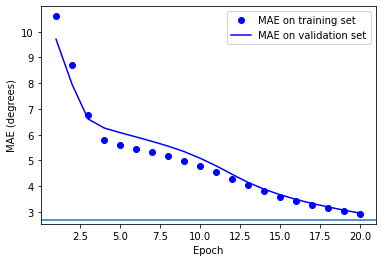

In [13]:
# Plot MAE cures for validation and training
plot_hist_regression(history_dense, baseline)

In [14]:
# We know that CNNs take advantage of neighbouring values, so why don't we try that?

# In addition to the Conv2D layers we saw last week, there are Conv1D and Conv3D layers. 
# Conv1D layers rely on 1D windows that slide across an input sequence (imagine a 1D image)

model_cnn = models.Sequential()
model_cnn.add(layers.Conv1D(8, 7, activation='relu', input_shape=(sequence_length, len(df.columns)-1)))
model_cnn.add(layers.MaxPooling1D(2))
model_cnn.add(layers.Conv1D(8, 3, activation='relu'))
model_cnn.add(layers.MaxPooling1D(2))
model_cnn.add(layers.GlobalAveragePooling1D())
model_cnn.add(layers.Dense(1))

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 8)              344       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 8)             0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 2, 8)              200       
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 8)             0         
 1D)                                                             
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                      

In [15]:
model_cnn.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_cnn = model_cnn.fit(train_dataset, epochs=n_epochs,
                            validation_data=val_dataset)

Epoch 1/20
80/80 [==============================] - 1s 11ms/step - loss: 117.7831 - mae: 9.4905 - val_loss: 90.3323 - val_mae: 7.9777
Epoch 2/20
80/80 [==============================] - 0s 5ms/step - loss: 56.0355 - mae: 6.3557 - val_loss: 32.7803 - val_mae: 4.6606
Epoch 3/20
80/80 [==============================] - 0s 5ms/step - loss: 19.4161 - mae: 3.6102 - val_loss: 19.7074 - val_mae: 3.3267
Epoch 4/20
80/80 [==============================] - 0s 5ms/step - loss: 16.2725 - mae: 3.2664 - val_loss: 18.6276 - val_mae: 3.1764
Epoch 5/20
80/80 [==============================] - 0s 5ms/step - loss: 14.9086 - mae: 3.1134 - val_loss: 17.8417 - val_mae: 3.0830
Epoch 6/20
80/80 [==============================] - 0s 5ms/step - loss: 13.8016 - mae: 2.9913 - val_loss: 17.1590 - val_mae: 3.0170
Epoch 7/20
80/80 [==============================] - 0s 5ms/step - loss: 12.9758 - mae: 2.9008 - val_loss: 16.6569 - val_mae: 2.9719
Epoch 8/20
80/80 [==============================] - 0s 5ms/step - loss: 12

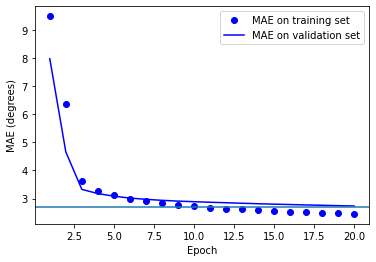

In [16]:
# Plot MAE cures for validation and training
plot_hist_regression(history_cnn, baseline)

In [17]:
# 1-layer LSTM

model_lstm1 = models.Sequential()
model_lstm1.add(layers.LSTM(20, input_shape=(sequence_length, len(df.columns)-1)))
model_lstm1.add(layers.Dense(1))

model_lstm1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                2160      
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________


In [18]:
n_epochs = 20
model_lstm1.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_lstm1 = model_lstm1.fit(train_dataset, epochs=n_epochs,
                            validation_data=val_dataset)

Epoch 1/20
80/80 [==============================] - 2s 14ms/step - loss: 134.9665 - mae: 10.4642 - val_loss: 104.1759 - val_mae: 8.9867
Epoch 2/20
80/80 [==============================] - 1s 7ms/step - loss: 77.9954 - mae: 7.5760 - val_loss: 55.3226 - val_mae: 5.9470
Epoch 3/20
80/80 [==============================] - 1s 7ms/step - loss: 45.7859 - mae: 5.5754 - val_loss: 37.8540 - val_mae: 4.8372
Epoch 4/20
80/80 [==============================] - 1s 7ms/step - loss: 32.8711 - mae: 4.6694 - val_loss: 29.4410 - val_mae: 4.2940
Epoch 5/20
80/80 [==============================] - 1s 7ms/step - loss: 25.4685 - mae: 4.0878 - val_loss: 23.9805 - val_mae: 3.8948
Epoch 6/20
80/80 [==============================] - 1s 7ms/step - loss: 20.3793 - mae: 3.6462 - val_loss: 19.9657 - val_mae: 3.5600
Epoch 7/20
80/80 [==============================] - 1s 7ms/step - loss: 16.6103 - mae: 3.2876 - val_loss: 16.9061 - val_mae: 3.2691
Epoch 8/20
80/80 [==============================] - 1s 7ms/step - loss: 

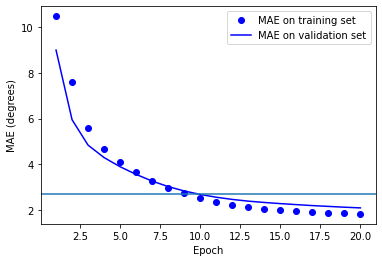

In [19]:
# Plot MAE cures for validation and training
plot_hist_regression(history_lstm1, baseline)

In [20]:
print('Test MAE = %.2f degrees' % model_lstm1.evaluate(test_dataset)[1])

31/31 [==============================] - 1s 17ms/step - loss: 7.5190 - mae: 2.1266
Test MAE = 2.13 degrees


In [21]:
# Adding dropout

model_lstm2 = models.Sequential()
model_lstm2.add(layers.LSTM(20, input_shape=(sequence_length, len(df.columns)-1), recurrent_dropout=0.25))
model_lstm2.add(layers.Dropout(0.4))
model_lstm2.add(layers.Dense(1))

model_lstm2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20)                2160      
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 2,181
Trainable params: 2,181
Non-trainable params: 0
_________________________________________________________________


In [22]:
model_lstm2.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history_lstm2 = model_lstm2.fit(train_dataset, epochs=n_epochs,
                            validation_data=val_dataset)

Epoch 1/20
80/80 [==============================] - 2s 17ms/step - loss: 138.6885 - mae: 10.6251 - val_loss: 120.2165 - val_mae: 9.7541
Epoch 2/20
80/80 [==============================] - 1s 10ms/step - loss: 102.1577 - mae: 9.0147 - val_loss: 78.1606 - val_mae: 7.7010
Epoch 3/20
80/80 [==============================] - 1s 10ms/step - loss: 61.5198 - mae: 6.5968 - val_loss: 45.0155 - val_mae: 5.2616
Epoch 4/20
80/80 [==============================] - 1s 11ms/step - loss: 39.9409 - mae: 5.1751 - val_loss: 34.3503 - val_mae: 4.5692
Epoch 5/20
80/80 [==============================] - 1s 10ms/step - loss: 33.5854 - mae: 4.6802 - val_loss: 28.1135 - val_mae: 4.1725
Epoch 6/20
80/80 [==============================] - 1s 10ms/step - loss: 27.0971 - mae: 4.1416 - val_loss: 23.2747 - val_mae: 3.8007
Epoch 7/20
80/80 [==============================] - 1s 10ms/step - loss: 23.3907 - mae: 3.8839 - val_loss: 20.1029 - val_mae: 3.5494
Epoch 8/20
80/80 [==============================] - 1s 10ms/step 

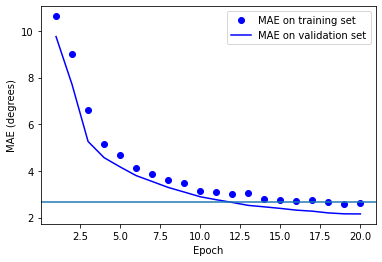

In [23]:
# Plot MAE cures for validation and training
plot_hist_regression(history_lstm2, baseline)

In [24]:
print('Test MAE = %.2f degrees' % model_lstm2.evaluate(test_dataset)[1])

31/31 [==============================] - 1s 15ms/step - loss: 7.7894 - mae: 2.1834
Test MAE = 2.18 degrees


In [25]:
# Performance in the previous figure can (maybe) still be improved
# Let's try to add some more layers -- we can do this now that we're no longer overfitting

model_lstm3 = models.Sequential()
model_lstm3.add(layers.LSTM(20, input_shape=(sequence_length, len(df.columns)-1), recurrent_dropout=0.25, return_sequences=True))  # NEW!
model_lstm3.add(layers.LSTM(20, input_shape=(sequence_length, len(df.columns)-1), recurrent_dropout=0.25))  # NEW!!
model_lstm3.add(layers.Dropout(0.4))
model_lstm3.add(layers.Dense(1))
model_lstm3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 20)            2160      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3280      
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 5,461
Trainable params: 5,461
Non-trainable params: 0
_________________________________________________________________


In [26]:
model_lstm3.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])

callbacks = [EarlyStopping(monitor='val_mae', patience=2)]

history_lstm3 = model_lstm3.fit(train_dataset, epochs=60,  # increased number of epochs
                            validation_data=val_dataset,
                            callbacks=callbacks)  # but added early stopping callback


Epoch 1/60
80/80 [==============================] - 4s 24ms/step - loss: 116.7657 - mae: 9.6224 - val_loss: 68.0089 - val_mae: 6.8792
Epoch 2/60
80/80 [==============================] - 1s 15ms/step - loss: 51.3344 - mae: 5.9022 - val_loss: 38.4054 - val_mae: 4.8980
Epoch 3/60
80/80 [==============================] - 1s 15ms/step - loss: 34.8893 - mae: 4.7910 - val_loss: 29.8076 - val_mae: 4.3269
Epoch 4/60
80/80 [==============================] - 1s 16ms/step - loss: 28.6260 - mae: 4.3005 - val_loss: 25.3571 - val_mae: 4.0388
Epoch 5/60
80/80 [==============================] - 1s 15ms/step - loss: 25.8818 - mae: 4.0805 - val_loss: 22.4954 - val_mae: 3.8407
Epoch 6/60
80/80 [==============================] - 1s 15ms/step - loss: 21.3870 - mae: 3.6629 - val_loss: 19.5634 - val_mae: 3.5788
Epoch 7/60
80/80 [==============================] - 1s 15ms/step - loss: 19.1060 - mae: 3.5119 - val_loss: 18.1564 - val_mae: 3.4673
Epoch 8/60
80/80 [==============================] - 1s 15ms/step - l

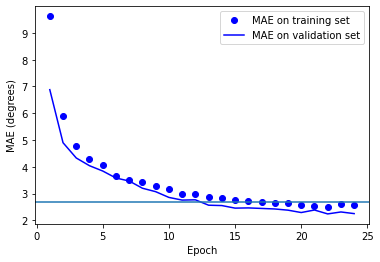

31/31 [==============================] - 1s 17ms/step - loss: 8.4832 - mae: 2.2770: 0s - loss: 8.2500 - mae: 2
Test MAE = 2.28 degrees


In [27]:
# Plot MAE cures for validation and training
plot_hist_regression(history_lstm3, baseline)
print('Test MAE = %.2f degrees' % model_lstm3.evaluate(test_dataset)[1])

In [28]:
def plot_hist_classif(hist):
  n_ = len(hist.history['accuracy'])
  plt.plot(range(1, n_+1), 100*np.asarray(hist.history['accuracy']), 'bo', label='Accuracy on training set')
  plt.plot(range(1, n_+1), 100*np.asarray(hist.history['val_accuracy']), 'b', label='Accuracy on validation set')
  plt.legend()
  plt.xlabel("Epoch") 
  plt.ylabel("Accuracy")
  plt.ylim(0, 100)
  plt.axhline(y=50)
  plt.show()

In [29]:
max_features = 15000  # only consider the top 15k words
maxlen = 500  # first 500 words of each review
batch_size = 32

print('Loading data...')
# Load dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences', x_train.shape)
print(len(x_test), 'test sequences', x_test.shape)

Loading data...
17473536/17464789 [==============================] - 2s 0us/step
25000 train sequences (25000,)
25000 test sequences (25000,)


In [30]:
# How balanced is this dataset?
print(np.sum(y_train)/len(y_train))
print(np.sum(y_test)/len(y_test))

0.5
0.5


In [31]:
# Merge the two datasets and divide: 60% for training, 20% validation, 20% test
x_, y_ = np.concatenate((x_train, x_test)), np.concatenate((y_train, y_test))
print(x_.shape, y_.shape)
x_train, x_test, y_train, y_test = train_test_split(x_, y_, test_size=0.4, random_state=10)  # 60/40 split
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=10)  # 50/50 split
print(len(x_train), 'train sequences', x_train.shape)
print(len(x_val), 'validation sequences', x_val.shape)
print(len(x_test), 'test sequences', x_test.shape)

(50000,) (50000,)
30000 train sequences (30000,)
10000 validation sequences (10000,)
10000 test sequences (10000,)


In [32]:
x_train[0][:10]  # numbers!!

[1, 11531, 186, 8, 28, 6, 6482, 7, 269, 4042]

In [33]:
# We can explore what one of the reviews looks like at this point.

# Retrieve the word index file that maps words to indices
word_index = keras.datasets.imdb.get_word_index()
# Reverse the word index to obtain a dict mapping indices to words (which is what we have)
inverted_word_index = dict((i, word) for (word, i) in word_index.items())
# Decode the first sequence in the dataset
decoded_sequence = " ".join(inverted_word_index[i] for i in x_train[0])
decoded_sequence

1654784/1641221 [==============================] - 0s 0us/step


"the lilly horror in one is fatale br looks meaningless in bronson be showing as you debut film ample to and ingredients zombi ample they for series and thought she's all manipulate and believing in j show look early last quote desire tight interesting that's kind out is far shelter but of frame br and"

In [34]:
# Let's ensure all sequences have the same length through padding
# - shorter reviews are padded with 0's
# - longer reviews are cut
print('Pad sequences')
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_val = keras.preprocessing.sequence.pad_sequences(x_val, maxlen=maxlen)
x_test = keras.preprocessing.sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_val shape:', x_val.shape)
print('x_test shape:', x_test.shape)

Pad sequences
x_train shape: (30000, 500)
x_val shape: (10000, 500)
x_test shape: (10000, 500)


In [35]:
# Basic feedforward model
model = models.Sequential()
model.add(layers.Embedding(max_features, 128, input_length=maxlen))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 128)          1920000   
                                                                 
 dense_6 (Dense)             (None, 500, 64)           8256      
                                                                 
 dropout_2 (Dropout)         (None, 500, 64)           0         
                                                                 
 dense_7 (Dense)             (None, 500, 64)           4160      
                                                                 
 dropout_3 (Dropout)         (None, 500, 64)           0         
                                                                 
 flatten_1 (Flatten)         (None, 32000)             0         
                                                                 
 dense_8 (Dense)             (None, 1)                

In [39]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=1, validation_data=(x_val, y_val))

938/938 [==============================] - 30s 32ms/step - loss: 0.2215 - accuracy: 0.9138 - val_loss: 0.2633 - val_accuracy: 0.8931


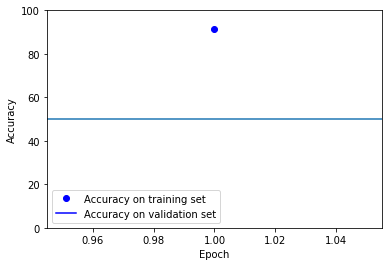

313/313 [==============================] - 2s 6ms/step - loss: 0.2634 - accuracy: 0.8938
Test Accuracy = 0.89


In [40]:
plot_hist_classif(history)
print('Test Accuracy = %.2f' % model.evaluate(x_test, y_test)[1])  # overfitting!

In [41]:
# Let's try an RNN
model = models.Sequential()
model.add(layers.Embedding(max_features, 64))
model.add(layers.LSTM(128, return_sequences=False))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation="sigmoid"))
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          960000    
                                                                 
 lstm_4 (LSTM)               (None, 128)               98816     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,058,945
Trainable params: 1,058,945
Non-trainable params: 0
_________________________________________________________________


In [42]:
# This model will take a long time to train, so we add an early stopping criterion
# N.B: It's actually much faster to train WITHOUT A GPU!!
callbacks = [EarlyStopping(monitor='val_accuracy', patience=2)]
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=20, validation_data=(x_val, y_val), callbacks=callbacks)
plot_hist_classif(history)
print('Test Accuracy = %.2f' % model.evaluate(x_test, y_test)[1])
# Note that we're still overfitting, but this is just an example of use

Epoch 1/20
 60/938 [>.............................] - ETA: 3:11 - loss: 0.7548 - accuracy: 0.5615

KeyboardInterrupt: 

# The Exercise Attempt

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_21 (Embedding)    (None, None, 64)          960000    
                                                                 
 bidirectional_27 (Bidirecti  (None, None, 64)         24832     
 onal)                                                           
                                                                 
 bidirectional_28 (Bidirecti  (None, None, 64)         24832     
 onal)                                                           
                                                                 
 dropout_25 (Dropout)        (None, None, 64)          0         
                                                                 
 lstm_45 (LSTM)              (None, None, 64)          33024     
                                                                 
 dropout_26 (Dropout)        (None, None, 64)        

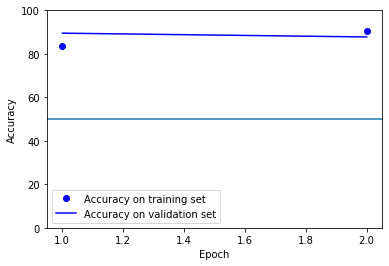

313/313 [==============================] - 97s 307ms/step - loss: 0.2687 - accuracy: 0.8937
Test Accuracy = 0.89


In [66]:
n_ = 5  # number of epochs. You can edit this

model = models.Sequential()
# YOUR CODE HERE!
model.add(layers.Embedding(max_features, 64))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True)))
model.add(layers.Dropout(0.5))
model.add(layers.LSTM(64, return_sequences=True))
model.add(layers.Dropout(0.5))
model.add(layers.LSTM(64))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation="sigmoid"))

# I DON'T RECOMMEND THAT YOU CHANGE CODE AFTER THIS POINT
model.compile(optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"])
print(model.summary())

# This model will take a long time to train, so we add an early stopping criterion
# I've also added a ModelCheckpoint that will save the best model according to val_accuracy regardless of whether we continue training
callbacks = [EarlyStopping(monitor='val_accuracy', patience=1),
             ModelCheckpoint("model.keras", save_best_only=True, monitor="val_accuracy", mode='max')]

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=n_, 
                    validation_data=(x_val, y_val), 
                    callbacks=callbacks)
plot_hist_classif(history)
model = keras.models.load_model("model.keras")
print('Test Accuracy = %.2f' % model.evaluate(x_test, y_test)[1])

In [67]:
if model.count_params() > 1000000:
    print("Due to memory constraints on Moodle, the lab quiz has a 10MB limit on your model size, so you need to use a smaller model to validate through the auto-marker.")

if history.history["val_accuracy"][-1] > 0.9:
    print("Your model is accurate enough!")

else:
    print("Accuracy is below the threshold!")
    raise Exception("Your model isn't accurate enough to pass the progress checker!")
# Save the model into a local folder
keras.models.save_model(model, "Model.h5",save_format='h5')
print('Model saved! You can now upload it to the lab quiz.')

Due to memory constraints on Moodle, the lab quiz has a 10MB limit on your model size, so you need to use a smaller model to validate through the auto-marker.
Accuracy is below the threshold!


Exception: Your model isn't accurate enough to pass the progress checker!